In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pim_tmr as pim
import matrices as pim_mats
import fibernet
import torch
from admm import admm_tmr
import matplotlib.pyplot as plt

In [2]:
import mat73
import os
from scipy.io import loadmat

path = "C:\\Users\\saucourt\\Datasets"
file = "data_base_02_03_90deg.mat"
data = mat73.loadmat(os.path.join(path, file))
# data = loadmat(os.path.join(path, file))

In [3]:
model_path = 'C:/Users/saucourt/Coding/fibernet_analysis/training_analysis/trained_models/model_ds=10k_p=1_na=0.2_ep=40.pth'
model = torch.load(model_path)

In [4]:
def retrieve_bias(model):
    return model.bias.cpu().detach().numpy()

def retrieve_matrix(model, num_mats) -> None:
    return [params.data for i in range(num_mats) for params in model.linear_list[i].parameters()][0].cpu().detach().numpy()
    
matrix = retrieve_matrix(model, 1)
bias = retrieve_bias(model)

print(np.transpose(matrix).shape)
print(bias.shape)

(32, 14884)
(122, 122)


In [5]:
CP = np.reshape(np.array(data['CP']), newshape=(-1, 128, 128))
vec = np.reshape(np.array(data['vecteur_36']) , newshape=(-1, 36))

NN = CP.shape[0]
As = np.zeros(shape=(NN, 32), dtype=complex)
Bs = np.zeros(shape=(NN, 122*122), dtype=float)

amp = fibernet.dataset._utils.make_bellshaped_plane_2d(vec[0].reshape((6,6)))
amp = amp.flatten()

for i in range(NN):
    phi = vec[i]
    phi = amp * np.exp(1j * phi)
    phi = np.delete(vec[i], [0, 5, 30, 35])
    img = CP[i][3:125, 3:125]
    # img = img - bias
    img = img.flatten().astype('float')
    As[i,:] = phi
    Bs[i,:] = np.sqrt(img/(np.power(2, 16) - 1))

In [6]:
torch.cuda.empty_cache()
N = 500
idx = np.random.permutation(np.arange(NN))
As_crop = As[idx[:N], :]
Bs_crop = Bs[idx[:N], :]

# Tolerance criterion has to be adjusted to be realistic and ensure the convergence
X_est = admm_tmr(As_crop, Bs_crop, rho=1, max_iter=15, max_inner_iter=100, tol=1e-2, lr=1e-2, verbose=1, device='cuda')
X_est = X_est.cpu().detach().numpy()

# Normalize retrieved matrix
X1 = np.abs(X_est) / np.max(np.abs(X_est)) * np.exp(1j * (np.angle(X_est) - np.angle(X_est[0, :])))

Iteration:   1 - distance = 3.864e+01 - stopping distance = 3.564e+01
Iteration:   2 - distance = 1.301e+01 - stopping distance = 2.563e+01
Iteration:   3 - distance = 1.629e+00 - stopping distance = 1.138e+01
Iteration:   4 - distance = 8.408e-01 - stopping distance = 7.886e-01
Iteration:   5 - distance = 7.108e-01 - stopping distance = 1.300e-01
Iteration:   6 - distance = 6.411e-01 - stopping distance = 6.978e-02
Iteration:   7 - distance = 6.311e-01 - stopping distance = 9.986e-03
Convergence detected: 9.986e-03 < 1.00e-02 


[(-0.5, 121.5, 121.5, -0.5),
 (-0.5, 121.5, 121.5, -0.5),
 (-0.5, 121.5, 121.5, -0.5),
 (-0.5, 121.5, 121.5, -0.5)]

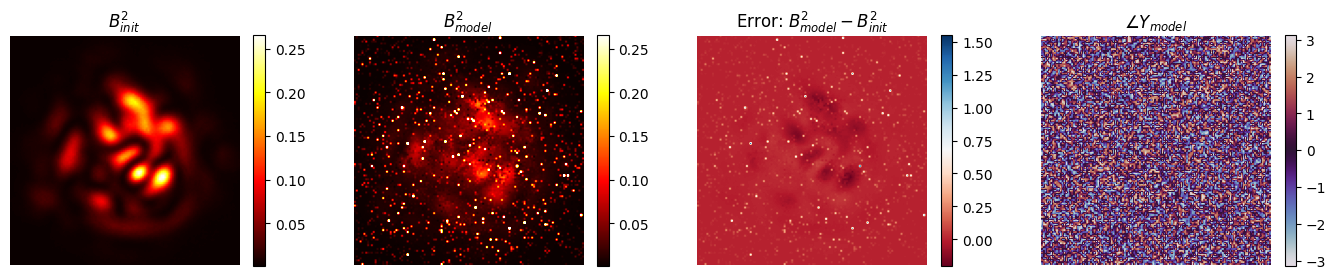

In [15]:
i = np.random.randint(0, N)
A_init = As_crop[i,:]
Y_model = np.dot(X_est.T, A_init).reshape((122,122))
B_model = np.abs(Y_model)
B_init = Bs_crop[i,:].reshape((122,122))

fig, axs = plt.subplots(1,4, figsize=(17,3))
pl0 = axs[0].imshow(np.square(B_init), cmap="hot")
pl1 = axs[1].imshow(np.square(B_model), cmap="hot", vmin=np.min(np.square(B_init)), vmax=np.max(np.square(B_init)))
pl2 = axs[2].imshow(np.square(B_model) - np.square(B_init), cmap="RdBu")
pl3 = axs[3].imshow(np.angle(Y_model), cmap="twilight")
plt.colorbar(pl0, ax=axs[0])
plt.colorbar(pl1, ax=axs[1])
plt.colorbar(pl2, ax=axs[2])
plt.colorbar(pl3, ax=axs[3])
axs[0].set_title(r"$B_{init}^2$")
axs[1].set_title(r"$B_{model}^2$")
axs[2].set_title(r"Error: $B_{model}^2 - B_{init}^2$")
axs[3].set_title(r"$\angle Y_{model}$")
[ axs[i].axis('off') for i in range(4) ]